In [2]:
import os
import cv2
import numpy as np
import mlflow
import joblib
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from keras_balanced_batch_generator import make_generator
from matplotlib import pyplot as plt
from matplotlib.image import imread

## Prepare data

In [3]:
examples = []
labels = []

for file in os.listdir("train"):
    img = cv2.resize(cv2.imread('train/' + file, 0), (200, 200), interpolation = cv2.INTER_CUBIC)
    examples.append(img)
    if file.startswith('cat'):
        labels.append(0)
    else:
        labels.append(1)

## Descriptor

In [4]:
winSize = (200, 200)
blockSize = (100, 100)
blockStride = (20, 20)
cellSize = (50, 50)
    
def get_hog():
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                            histogramNormType, L2HysThreshold, gammaCorrection, nlevels, signedGradient)

    return hog

In [5]:
hog = get_hog()

In [6]:
hog_descriptors = []
for img in examples:
    hog_descriptors.append(hog.compute(img))
hog_descriptors = np.squeeze(hog_descriptors)

In [7]:
train_n = int(0.9 * len(hog_descriptors))
train_examples, test_examples, train_hog_descriptors, test_hog_descriptors, train_labels, test_labels =\
    train_test_split(examples, hog_descriptors, labels, test_size=0.1, random_state=42, stratify = labels)
train_examples, test_examples, train_hog_descriptors, test_hog_descriptors, train_labels, test_labels =\
    np.array(train_examples), np.array(test_examples), np.array(train_hog_descriptors), np.array(test_hog_descriptors), np.array(train_labels), np.array(test_labels) 
#train_hog_descriptors, test_hog_descriptors, train_labels, test_labels = train_test_split(hog_descriptors, labels, test_size=0.1, random_state=42, stratify = labels)

In [ ]:
train_hog_descriptors.shape

## Grid search

In [19]:
# parameters = {"SVM__C": np.linspace(0.2, 0.4, 6),
#              "SVM__gamma": np.linspace(0.002, 0.004, 6),
#              "SVM__kernel": ['poly']}

In [20]:
# pipeline = Pipeline(steps=[('StandardScaler', StandardScaler()), ('SVM', SVC())])
# clf = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1)
# clf.fit(train_hog_descriptors[:2500], train_labels[:2500])

GridSearchCV(estimator=Pipeline(steps=[('StandardScaler', StandardScaler()),
                                       ('SVM', SVC())]),
             n_jobs=-1,
             param_grid={'SVM__C': array([0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ]),
                         'SVM__gamma': array([0.002 , 0.0024, 0.0028, 0.0032, 0.0036, 0.004 ]),
                         'SVM__kernel': ['poly']})

In [21]:
# clf.best_params_

{'SVM__C': 0.28, 'SVM__gamma': 0.0028, 'SVM__kernel': 'poly'}

## Algorithm

In [8]:
params = {
#     'activation': 'relu',
#     'batch_size': 128,
#     'early_stopping': True,
#     'hidden_layer_sizes': (1000, 800, 600),
#     'learning_rate': 'adaptive',
#     'learning_rate_init': 0.03,
#     'n_iter_no_change': 30,
#     'random_state': 42,
#     'solver': 'sgd',
#     'verbose': True
    'C': 1.9,
    'gamma': 0.00092
}

model = SVC(**params)
clf = make_pipeline(StandardScaler(), model)
clf.fit(train_hog_descriptors, train_labels)
print("clf fitted")

pred = clf.predict(test_hog_descriptors)

clf fitted


In [9]:
accuracy = (accuracy_score(pred, test_labels)*100)
print(accuracy)

82.64


In [10]:
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1250
           1       0.83      0.83      0.83      1250

    accuracy                           0.83      2500
   macro avg       0.83      0.83      0.83      2500
weighted avg       0.83      0.83      0.83      2500



## Adding model to MLFlow

In [186]:
# experiment_name = "SVM"
# mlflow.set_experiment(experiment_name)
# with mlflow.start_run():
#     # Log SVM params
#     for param in params.keys():
#         mlflow.log_param(param, params[param])
#     # Log metrics
#     mlflow.log_metric("accuracy", accuracy)

## Saving model

In [11]:
filename = 'SVM.sav'
joblib.dump(clf, filename)

['SVM.sav']

## Load model

In [ ]:
# loaded_model = joblib.load('SVM.sav')

100.0


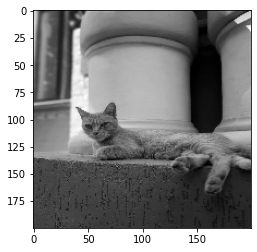

In [18]:
kitty = cv2.resize(cv2.imread('my_test/kitty3.jpg', 0), (200, 200), interpolation = cv2.INTER_CUBIC)

my_hog_descriptors = []
my_hog_descriptors.append(hog.compute(kitty))
my_hog_descriptors = np.squeeze(my_hog_descriptors)
my_labels = np.array([0])

my_hog_descriptors.reshape(-1, 1).T.shape
print(accuracy_score(clf.predict(my_hog_descriptors.reshape(-1, 1).T), my_labels)*100)
plt.imshow(kitty, cmap = 'gray')